In [329]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Let us start simply by loading the data and dropping irrelevant or duplicate collumns

In [330]:
# we three options of data to load:
# data/Data_merged_temp_features_normalisation_v1.csv
# data/Data_merged_temp_features_normalisation_v2.csv
# data/Data_merged_temp_features_normalisation_v3.csv
# v1 has features normalised within category this is potentially problematic
# v2 has features normalised across categories this is less problematic
# v3 has features normalised across categories, wherby negative time deltas are set to 0

pd.set_option('display.max_columns', None)
df_all_merged = pd.read_csv('data/Data_merged_temp_features_v3.csv')
df_all_merged.head()

,Unnamed: 0,org_uuid,org_name,domain,status,founded_on,category_list,category_groups_list,country_code,city,short_description,earliest_funding,time_first_funding,seed_funding,seed_funding_log,series_a_funding_date,time_till_series_a,series_a_funding,series_a_funding_log,seed_n_rounds,series_a_n_rounds,angel_n_rounds,pre_seed_n_rounds,success_flag,time_first_funding_normalised,seed_funding_normalised,series_a_funding_normalised,time_till_series_a_normalised
0,0,86bd89a7-fe3f-12d4-817c-8157c8592194,i.Sec,isec.ng,operating,2013-01-01,"Finance,FinTech",Financial Services,NGA,Lagos,i.Sec is a financial security service that all...,NaN,NaN,0.0,0.000000,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.0,0,0.410421,0.000000,0.000000,0.323669
1,1,58fd74f2-9ebb-4a41-cd75-05f9214a9a11,Kukua,kukua.me,operating,2015-01-01,"Content,EdTech,Franchise,Media and Entertainment","Education,Media and Entertainment,Other,Software",KEN,Nairobi,The edutainment company for children of the 21...,2018-11-08,1407 days,2500961.0,6.398107,2022-06-29,2736 days,6000000.0,6.778151,3.0,1.0,0.0,0.0,0,0.300448,0.005558,0.003985,0.619706
2,2,e8772824-d8d5-7636-0bd5-40b76511213b,Airdog,airdog.com,operating,2014-01-01,"Artificial Intelligence,Drones,Robotics","Artificial Intelligence,Consumer Electronics,C...",LVA,Riga,We build smart robots that bring unprecedented...,2015-03-19,442 days,2499329.0,6.397823,2016-07-18,929 days,3506665.0,6.544894,1.0,1.0,0.0,0.0,0,0.094384,0.005554,0.002329,0.210419
3,3,be72d0fa-b5b0-eb2d-f8aa-3cb290f97b33,Ubiq.ai,ubiq.ai,operating,2015-01-01,"Autonomous Vehicles,Car Sharing,Internet,Last ...","Internet Services,Real Estate,Software,Transpo...",AUT,Vienna,Ubiq is shaping the future of urban mobility b...,2015-04-09,98 days,1440559.0,6.158531,NaN,NaN,0.0,0.000000,1.0,0.0,0.0,1.0,0,0.020927,0.003201,0.000000,0.290283
4,4,7c9e6d25-8cf0-80a5-dfd6-d1a21337534d,ANKA,anka.africa,operating,2016-01-01,"Art,E-Commerce,Fashion,Handmade","Clothing and Apparel,Commerce and Shopping,Con...",CIV,Abidjan,"ANKA is a platform to discover, buy, and sell ...",2017-06-21,537 days,8076881.0,6.907244,NaN,NaN,0.0,0.000000,5.0,0.0,0.0,1.0,0,0.114670,0.017949,0.000000,0.557327


In [331]:
drop_col_list = ['earliest_funding', 
                 'domain', 
                 'org_uuid',
                 'country_code',
                 'series_a_funding_log',
                 'org_name',
                 'seed_funding_log',
                 'series_a_funding', 
                 'city', 
                 'short_description', 
                 'founded_on', 
                 'category_list', 
                 'seed_funding', 
                 'time_first_funding', 
                 'status', 
                 'Unnamed: 0', 
                 'time_till_series_a', 
                 'category_groups_list', 
                 'series_a_funding_date']


df_all_clean = df_all_merged.drop(labels = drop_col_list, axis=1)


In [332]:
df_all_clean.head()


,seed_n_rounds,series_a_n_rounds,angel_n_rounds,pre_seed_n_rounds,success_flag,time_first_funding_normalised,seed_funding_normalised,series_a_funding_normalised,time_till_series_a_normalised
0,0.0,0.0,0.0,0.0,0,0.410421,0.000000,0.000000,0.323669
1,3.0,1.0,0.0,0.0,0,0.300448,0.005558,0.003985,0.619706
2,1.0,1.0,0.0,0.0,0,0.094384,0.005554,0.002329,0.210419
3,1.0,0.0,0.0,1.0,0,0.020927,0.003201,0.000000,0.290283
4,5.0,0.0,0.0,1.0,0,0.114670,0.017949,0.000000,0.557327


Lets start modelling, we will start of with logistic regression, and L1/L2 regularisation variants.

In [333]:
# data
y = df_all_clean.pop('success_flag').to_frame()
X = df_all_clean

In [334]:
# train/test split and 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

log_reg_model_vanilla = LogisticRegression(random_state=0, penalty='none', max_iter=300)
log_reg_model_vanilla.fit(X_train, y_train)
mean_acc = log_reg_model_vanilla.score(X_test, y_test)
print("mean accuracy of vanilla logistic regression is: " + str(mean_acc))

mean accuracy of vanilla logistic regression is: 0.8083881578947368


Now we can try L1 regularisation

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

log_reg_model_l1 = LogisticRegression(random_state=0, penalty='l1', solver='saga',max_iter=300)
log_reg_model_l1.fit(X_train, y_train)
mean_acc = log_reg_model_l1.score(X_test, y_test)
print("mean accuracy of l1 logistic regression is: " + str(mean_acc))

mean accuracy of l1 logistic regression is: 0.7508223684210527


/Users/jrubruck/opt/anaconda3/envs/VelaMoneyball/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Now we can try L2 regularisation

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

log_reg_model_l2 = LogisticRegression(random_state=0, penalty='l2',max_iter=300)
log_reg_model_l2.fit(X_train, y_train)
mean_acc = log_reg_model_l2.score(X_test, y_test)
print("mean accuracy of l2 logistic regression is: " + str(mean_acc))

mean accuracy of l2 logistic regression is: 0.7467105263157895


Okay, so regularisation does not seem to make a huge difference in this dataset. Given the quite large number of datapoints we should perhaps not expect the model to be prone to overfitting. Let's make some ROC curves for this

In [337]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs_vanilla = log_reg_model_vanilla.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_vanilla = lr_probs_vanilla[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc_vanilla = roc_auc_score(y_test, lr_probs_vanilla)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc_vanilla))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs_vanilla)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.822


Text(0.5, 1.0, 'ROC Curve Vanilla Logisitc Regression')

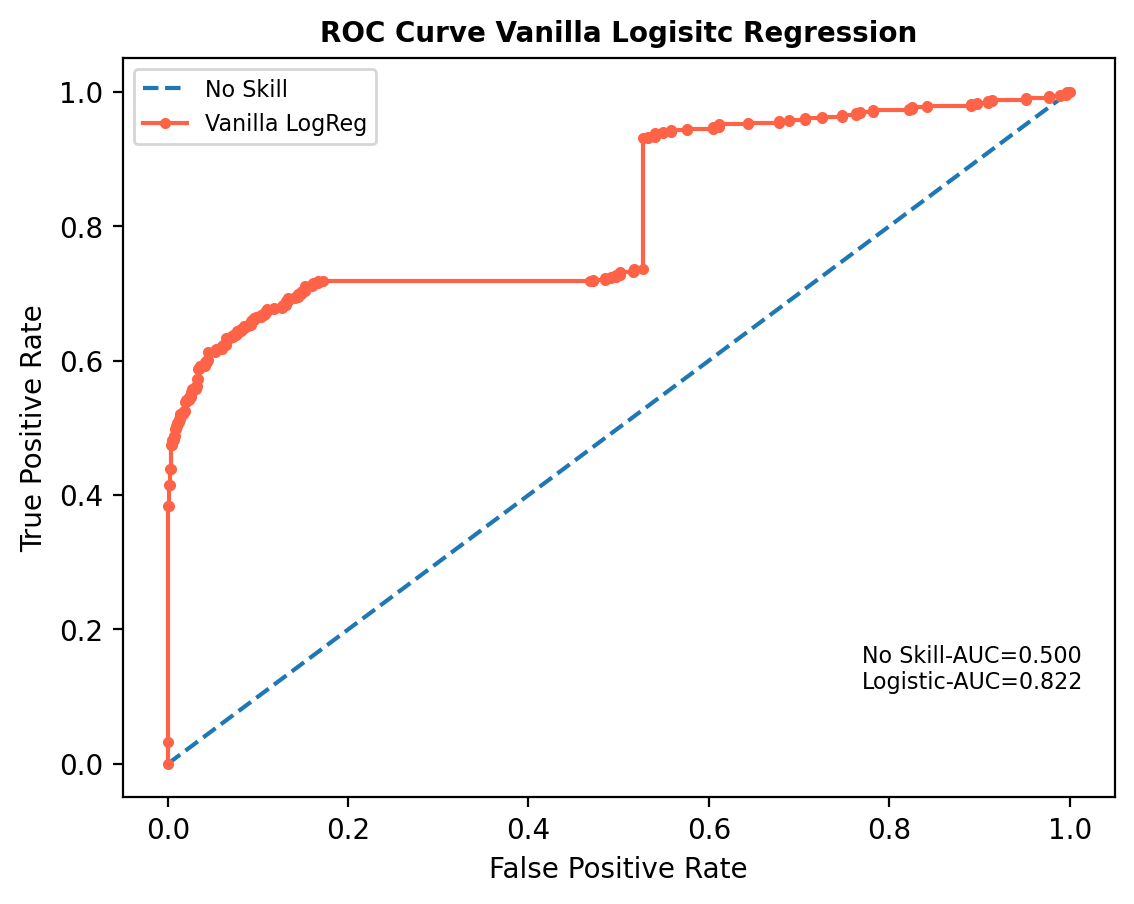

In [338]:
# Lets plot this

fig, ax = plt.subplots(dpi=200, facecolor='w')
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(lr_fpr, lr_tpr, marker='.', label='Vanilla LogReg', color='tomato')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize=8)
# make a second legend with mean, median, and sd
ax.annotate('No Skill-AUC=%.3f\nLogistic-AUC=%.3f' % (ns_auc, lr_auc_vanilla), 
            xy=(.745, .14), 
            xycoords='axes fraction', 
            fontsize=8,
            horizontalalignment='left', 
            verticalalignment='bottom')
ax.set_title('ROC Curve Vanilla Logisitc Regression', fontsize=10, fontweight='bold')

In [339]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs_l1 = log_reg_model_l1.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_l1 = lr_probs_l1[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc_l1 = roc_auc_score(y_test, lr_probs_l1)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc_l1))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs_l1)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.793


Text(0.5, 1.0, 'ROC Curve L1 Logisitc Regression')

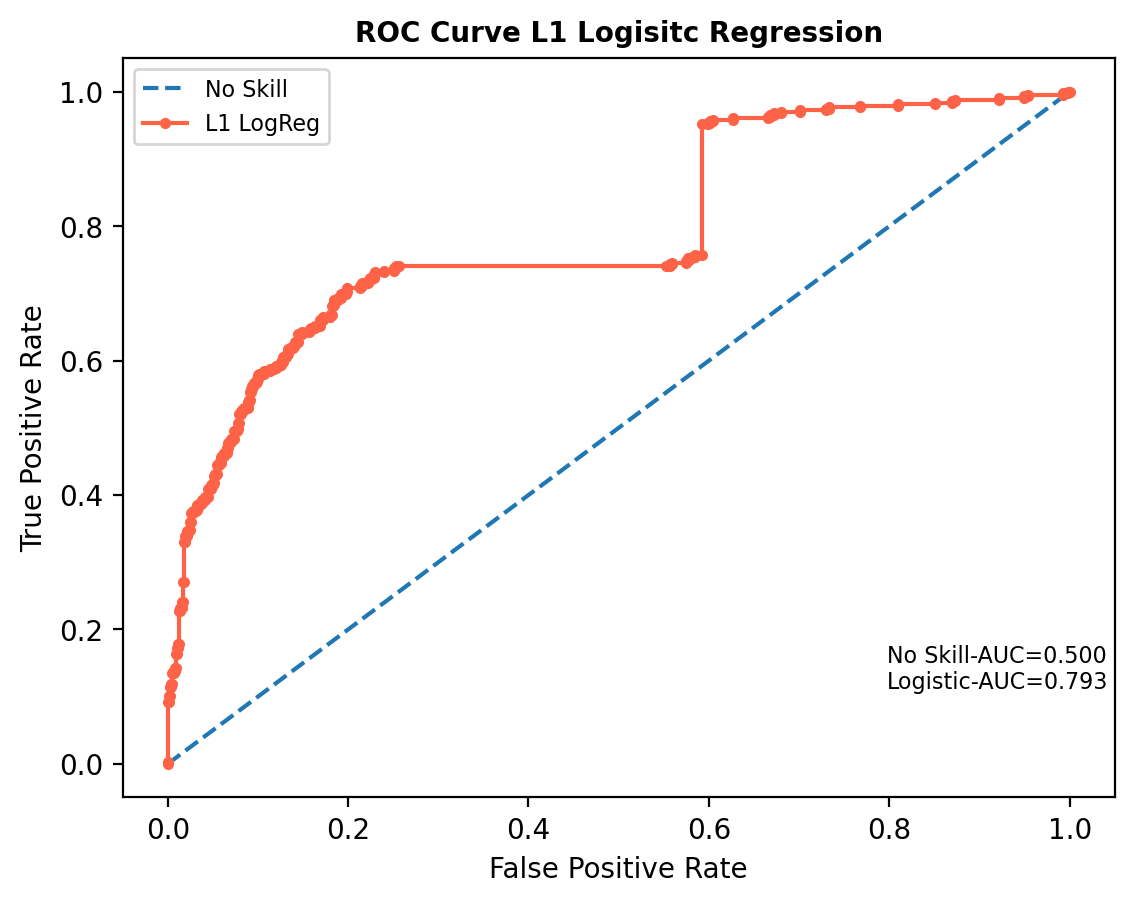

In [340]:
# Lets plot this

fig, ax = plt.subplots(dpi=200, facecolor='w')
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(lr_fpr, lr_tpr, marker='.', label='L1 LogReg', color='tomato')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize=8)
# make a second legend with mean, median, and sd
ax.annotate('No Skill-AUC=%.3f\nLogistic-AUC=%.3f' % (ns_auc, lr_auc_l1), 
            xy=(.77, .14), 
            xycoords='axes fraction', 
            fontsize=8,
            horizontalalignment='left', 
            verticalalignment='bottom')
ax.set_title('ROC Curve L1 Logisitc Regression', fontsize=10, fontweight='bold')

In [341]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs_l2 = log_reg_model_l2.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_l2 = lr_probs_l2[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc_l2 = roc_auc_score(y_test, lr_probs_l2)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc_l2))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs_l2)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.768


Text(0.5, 1.0, 'ROC Curve L2 Logisitc Regression')

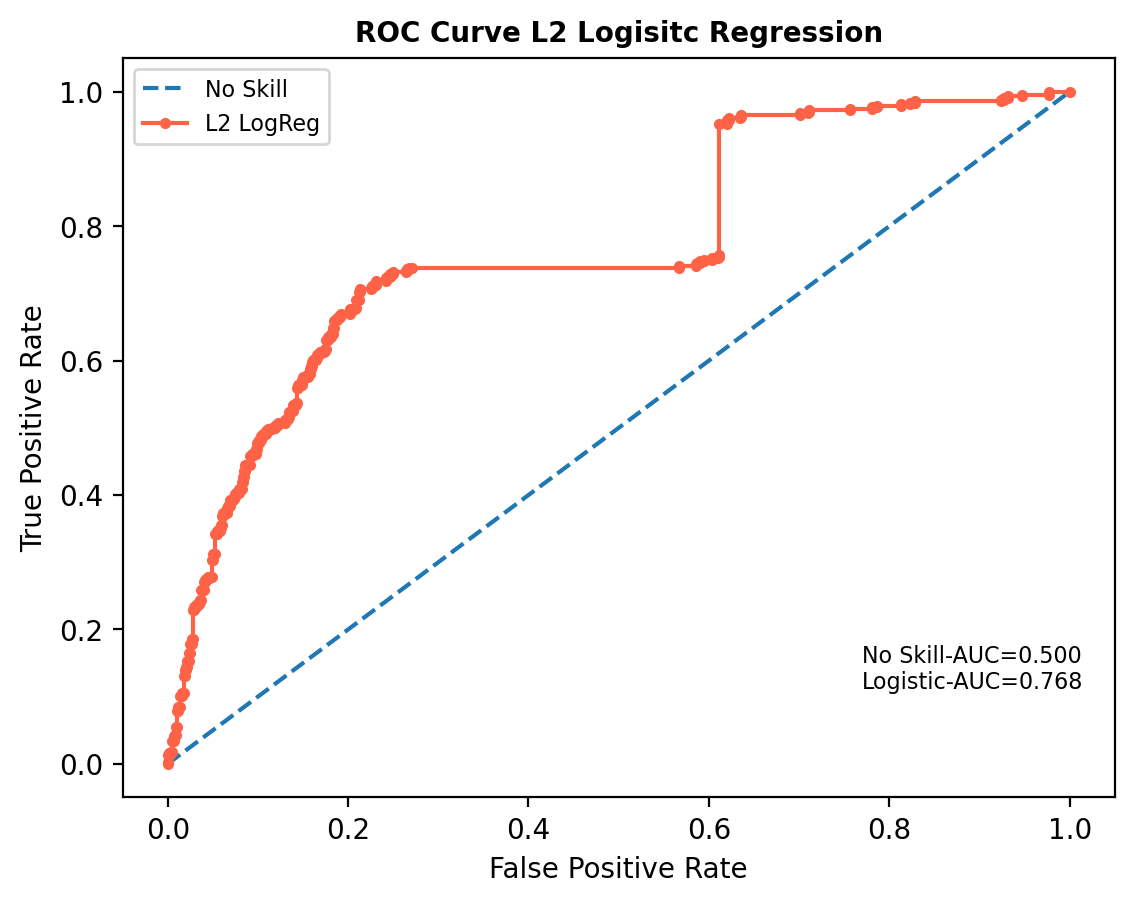

In [342]:
# Lets plot this

fig, ax = plt.subplots(dpi=200, facecolor='w')
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(lr_fpr, lr_tpr, marker='.', label='L2 LogReg', color='tomato')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize=8)
# make a second legend with mean, median, and sd
ax.annotate('No Skill-AUC=%.3f\nLogistic-AUC=%.3f' % (ns_auc, lr_auc_l2), 
            xy=(.745, .14), 
            xycoords='axes fraction', 
            fontsize=8,
            horizontalalignment='left', 
            verticalalignment='bottom')
ax.set_title('ROC Curve L2 Logisitc Regression', fontsize=10, fontweight='bold')

These are all quite similar, lets make a confusion matrix to get a better idea of Truepositive ratio etc.

In [343]:
y_pred = log_reg_model_vanilla.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion matrix of Vanilla Logisitc Regression')

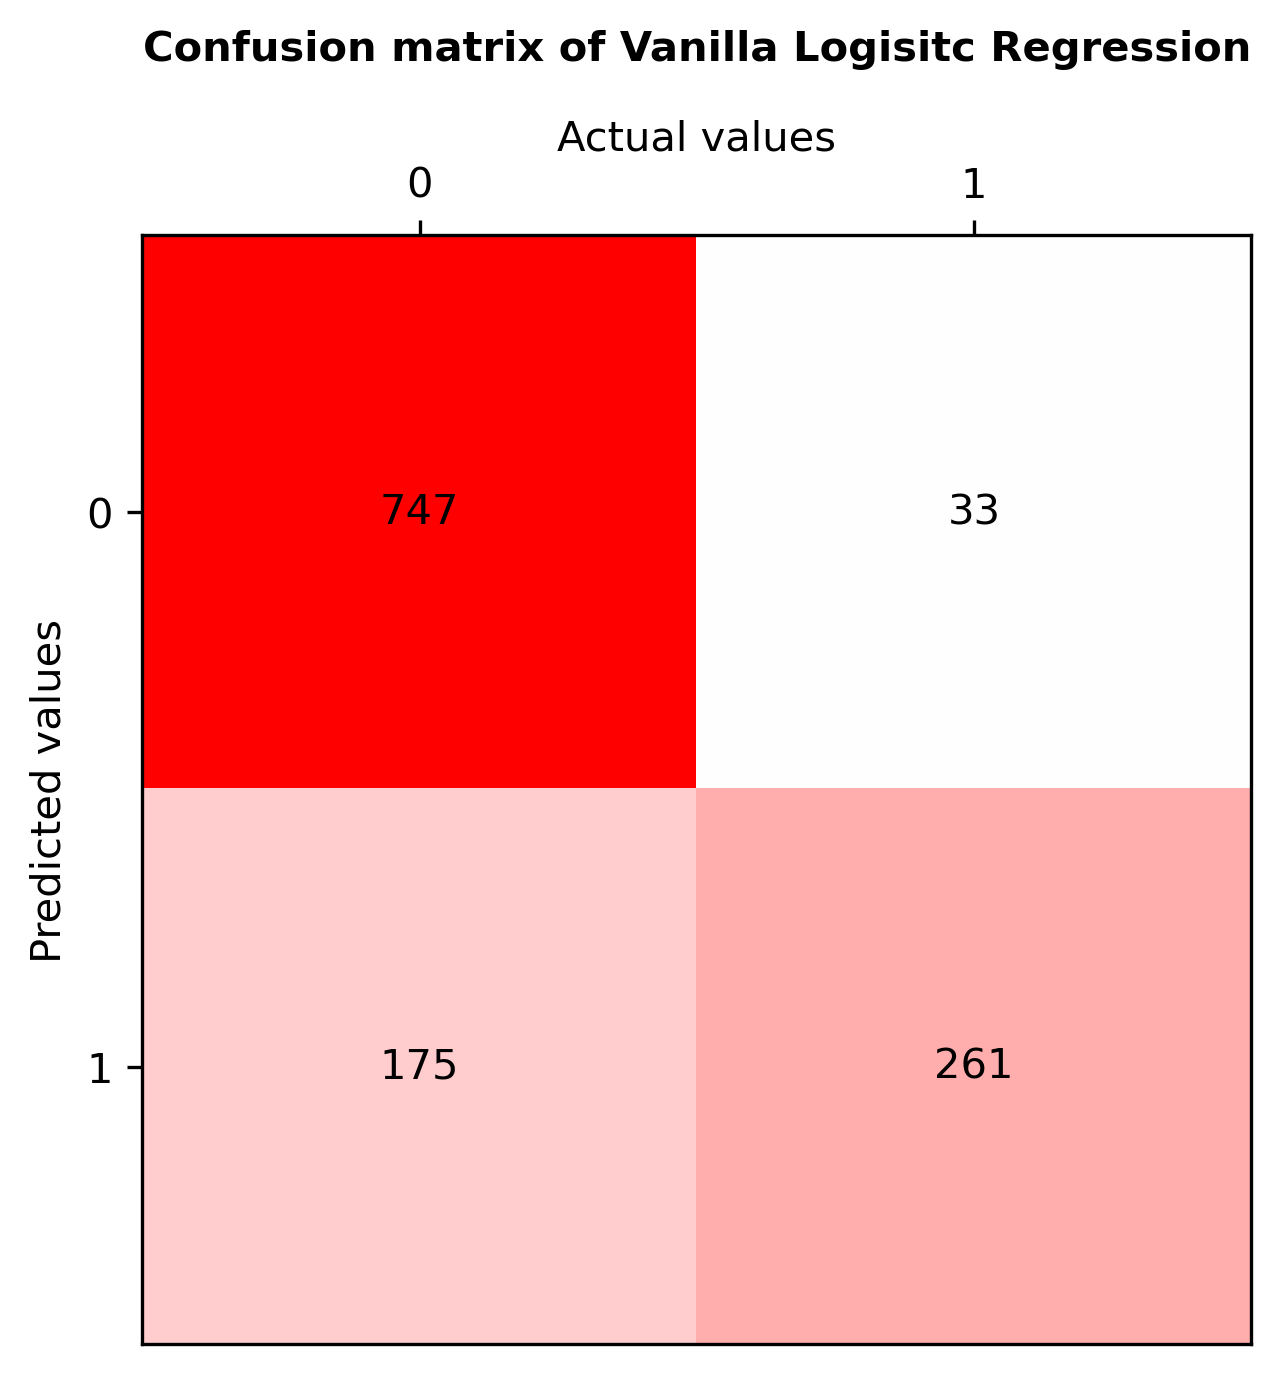

In [344]:
# Lets plot this
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

fig, ax = plt.subplots(dpi=300, facecolor='w')
cmap = plt.get_cmap('bwr')
new_cmap = truncate_colormap(cmap, 0.5, 1)

ax.matshow(cm, cmap=new_cmap)
ax.xaxis.set_label_position('top')
ax.set_xlabel('Actual values')
ax.set_ylabel('Predicted values')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False)

ax.set_xticks([0,1])
ax.set_xticklabels(['0','1'])

for i in range(2):
    for j in range(2):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

# # make a second legend with mean, median, and sd
# ax.annotate('No Skill-AUC=%.3f\nLogistic-AUC=%.3f' % (ns_auc, lr_auc_l2), 
#             xy=(.745, .14), 
#             xycoords='axes fraction', 
#             fontsize=8,
#             horizontalalignment='left', 
#             verticalalignment='bottom')

ax.set_title('Confusion matrix of Vanilla Logisitc Regression', fontsize=10, fontweight='bold', pad=14)

Make a new plot for with tpr, fnr, tnr, fpr

In [345]:
print(cm)
tpr = cm[1,1] / cm[:,1].sum()
fnr = cm[0,1] / cm[:,1].sum()
tnr = cm[0,0] / cm[:,0].sum()
fpr = cm[1,0] / cm[:,0].sum()
precision = cm[1,1] / cm[1,:].sum()
print('True Positive Rate=%.3f\nFalse Negative Rate=%.3f\nTrue Negative Rate=%.3f\nFalse Positive Rate=%.3f\nPrecision=%.3f' % 
     (tpr, fnr, tnr, fpr, precision))

[[747  33]
 [175 261]]
True Positive Rate=0.888
False Negative Rate=0.112
True Negative Rate=0.810
False Positive Rate=0.190
Precision=0.599


In [347]:
# make a random confusion matrix as baseline performance
y_pred_random = np.random.randint(2, size=y_pred.shape[0])
cm_random = confusion_matrix(y_test, y_pred_random)
print(cm_random)
tpr = cm_random[1,1] / cm_random[:,1].sum()
fnr = cm_random[0,1] / cm_random[:,1].sum()
tnr = cm_random[0,0] / cm_random[:,0].sum()
fpr = cm_random[1,0] / cm_random[:,0].sum()
precision = cm_random[1,1] / cm_random[1,:].sum()
print("random model:")
print('True Positive Rate=%.3f\nFalse Negative Rate=%.3f\nTrue Negative Rate=%.3f\nFalse Positive Rate=%.3f\nPrecision=%.3f' % 
     (tpr, fnr, tnr, fpr, precision))

[[412 368]
 [219 217]]
random model:
True Positive Rate=0.371
False Negative Rate=0.629
True Negative Rate=0.653
False Positive Rate=0.347
Precision=0.498


Lets now try to do this again while dropping series_a_n_rounds, and series_a_funding_normalised

In [289]:
drop_col_list_v2 = ['earliest_funding', 
                    'domain', 
                    'org_uuid',
                    'country_code',
                    'series_a_funding_log',
                    'org_name',
                    'seed_funding_log',
                    'series_a_funding', 
                    'city', 
                    'short_description', 
                    'founded_on', 
                    'category_list', 
                    'seed_funding', 
                    'time_first_funding', 
                    'status', 
                    'Unnamed: 0', 
                    'time_till_series_a', 
                    'category_groups_list', 
                    'series_a_funding_date',
                    'series_a_n_rounds', 
                    'series_a_funding_normalised']

df_all_clean_reduced = df_all_merged.drop(labels = drop_col_list_v2, axis=1)

In [290]:
df_all_clean_reduced.head()
# [ 25.33279676, -28.31952736, -16.28849181,   2.08453792,
#          0.21779949,   0.87549105]

,seed_n_rounds,angel_n_rounds,pre_seed_n_rounds,success_flag,time_first_funding_normalised,seed_funding_normalised,time_till_series_a_normalised
0,0.0,0.0,0.0,0,0.410421,0.000000,0.323669
1,3.0,0.0,0.0,0,0.300448,0.005558,0.619706
2,1.0,0.0,0.0,0,0.094384,0.005554,0.210419
3,1.0,0.0,1.0,0,0.020927,0.003201,0.290283
4,5.0,0.0,1.0,0,0.114670,0.017949,0.557327


In [291]:
# data
y = df_all_clean_reduced.pop('success_flag').to_frame()
X = df_all_clean_reduced

In [292]:
# train/test split and 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

log_reg_model_vanilla = LogisticRegression(random_state=0, penalty='none')
log_reg_model_vanilla.fit(X_train, y_train)
mean_acc = log_reg_model_vanilla.score(X_test, y_test)
print("mean accuracy of vanilla logistic regression is: " + str(mean_acc))

mean accuracy of vanilla logistic regression is: 0.7508223684210527


In [293]:
y_pred = log_reg_model_vanilla.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion matrix of Vanilla Logisitc Regression')

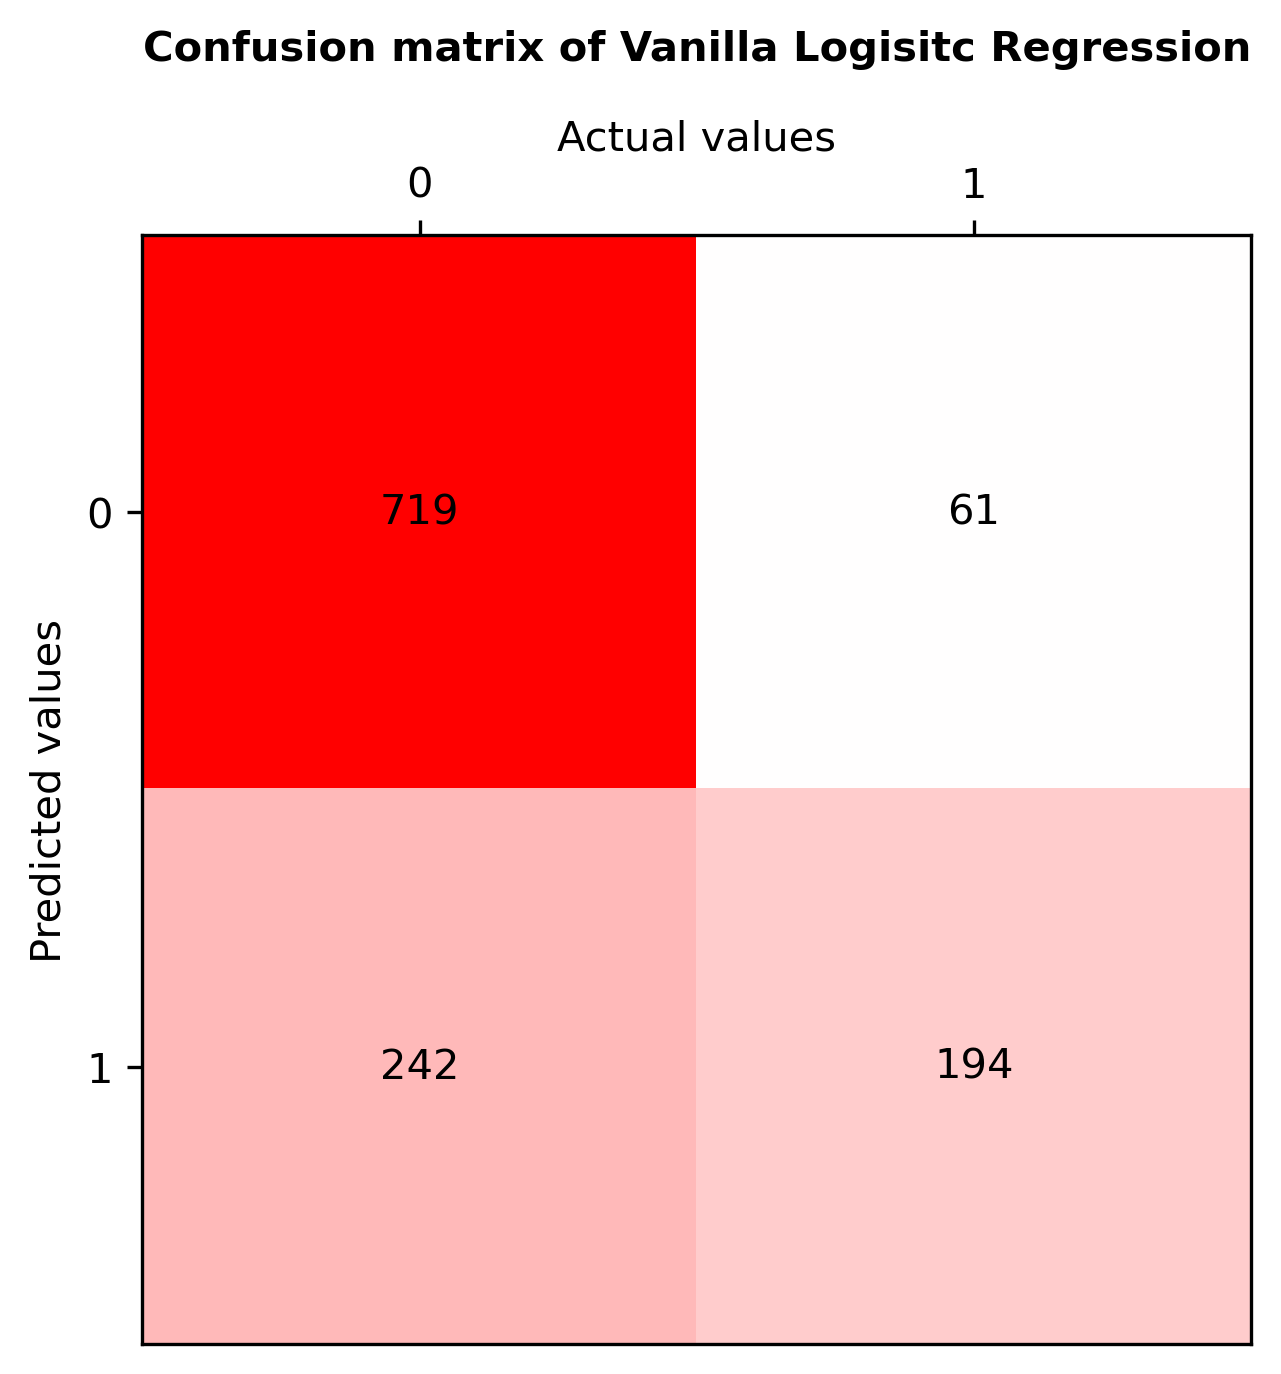

In [294]:
# Lets plot this
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

fig, ax = plt.subplots(dpi=300, facecolor='w')
cmap = plt.get_cmap('bwr')
new_cmap = truncate_colormap(cmap, 0.5, 1)

ax.matshow(cm, cmap=new_cmap)
ax.xaxis.set_label_position('top')
ax.set_xlabel('Actual values')
ax.set_ylabel('Predicted values')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False)

ax.set_xticks([0,1])
ax.set_xticklabels(['0','1'])

for i in range(2):
    for j in range(2):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

# # make a second legend with mean, median, and sd
# ax.annotate('No Skill-AUC=%.3f\nLogistic-AUC=%.3f' % (ns_auc, lr_auc_l2), 
#             xy=(.745, .14), 
#             xycoords='axes fraction', 
#             fontsize=8,
#             horizontalalignment='left', 
#             verticalalignment='bottom')

ax.set_title('Confusion matrix of Vanilla Logisitc Regression', fontsize=10, fontweight='bold', pad=14)

In [295]:
print(cm)
tpr = cm[1,1] / cm[:,1].sum()
fnr = cm[0,1] / cm[:,1].sum()
tnr = cm[0,0] / cm[:,0].sum()
fpr = cm[1,0] / cm[:,0].sum()
precision = cm[1,1] / cm[1,:].sum()
print('True Positive Rate=%.3f\nFalse Negative Rate=%.3f\nTrue Negative Rate=%.3f\nFalse Positive Rate=%.3f\nPrecision=%.3f' % 
     (tpr, fnr, tnr, fpr, precision))

[[719  61]
 [242 194]]
True Positive Rate=0.761
False Negative Rate=0.239
True Negative Rate=0.748
False Positive Rate=0.252
Precision=0.445


In [247]:
log_reg_model_vanilla.coef_[0]

array([-0.27430201, -0.35376894, -0.14070869, -0.50137645, 64.96407166,
       -5.47387782])

Now let us try to plot the feature importance

Text(0.5, 1.0, 'Magnitude of weights in logistic regression')

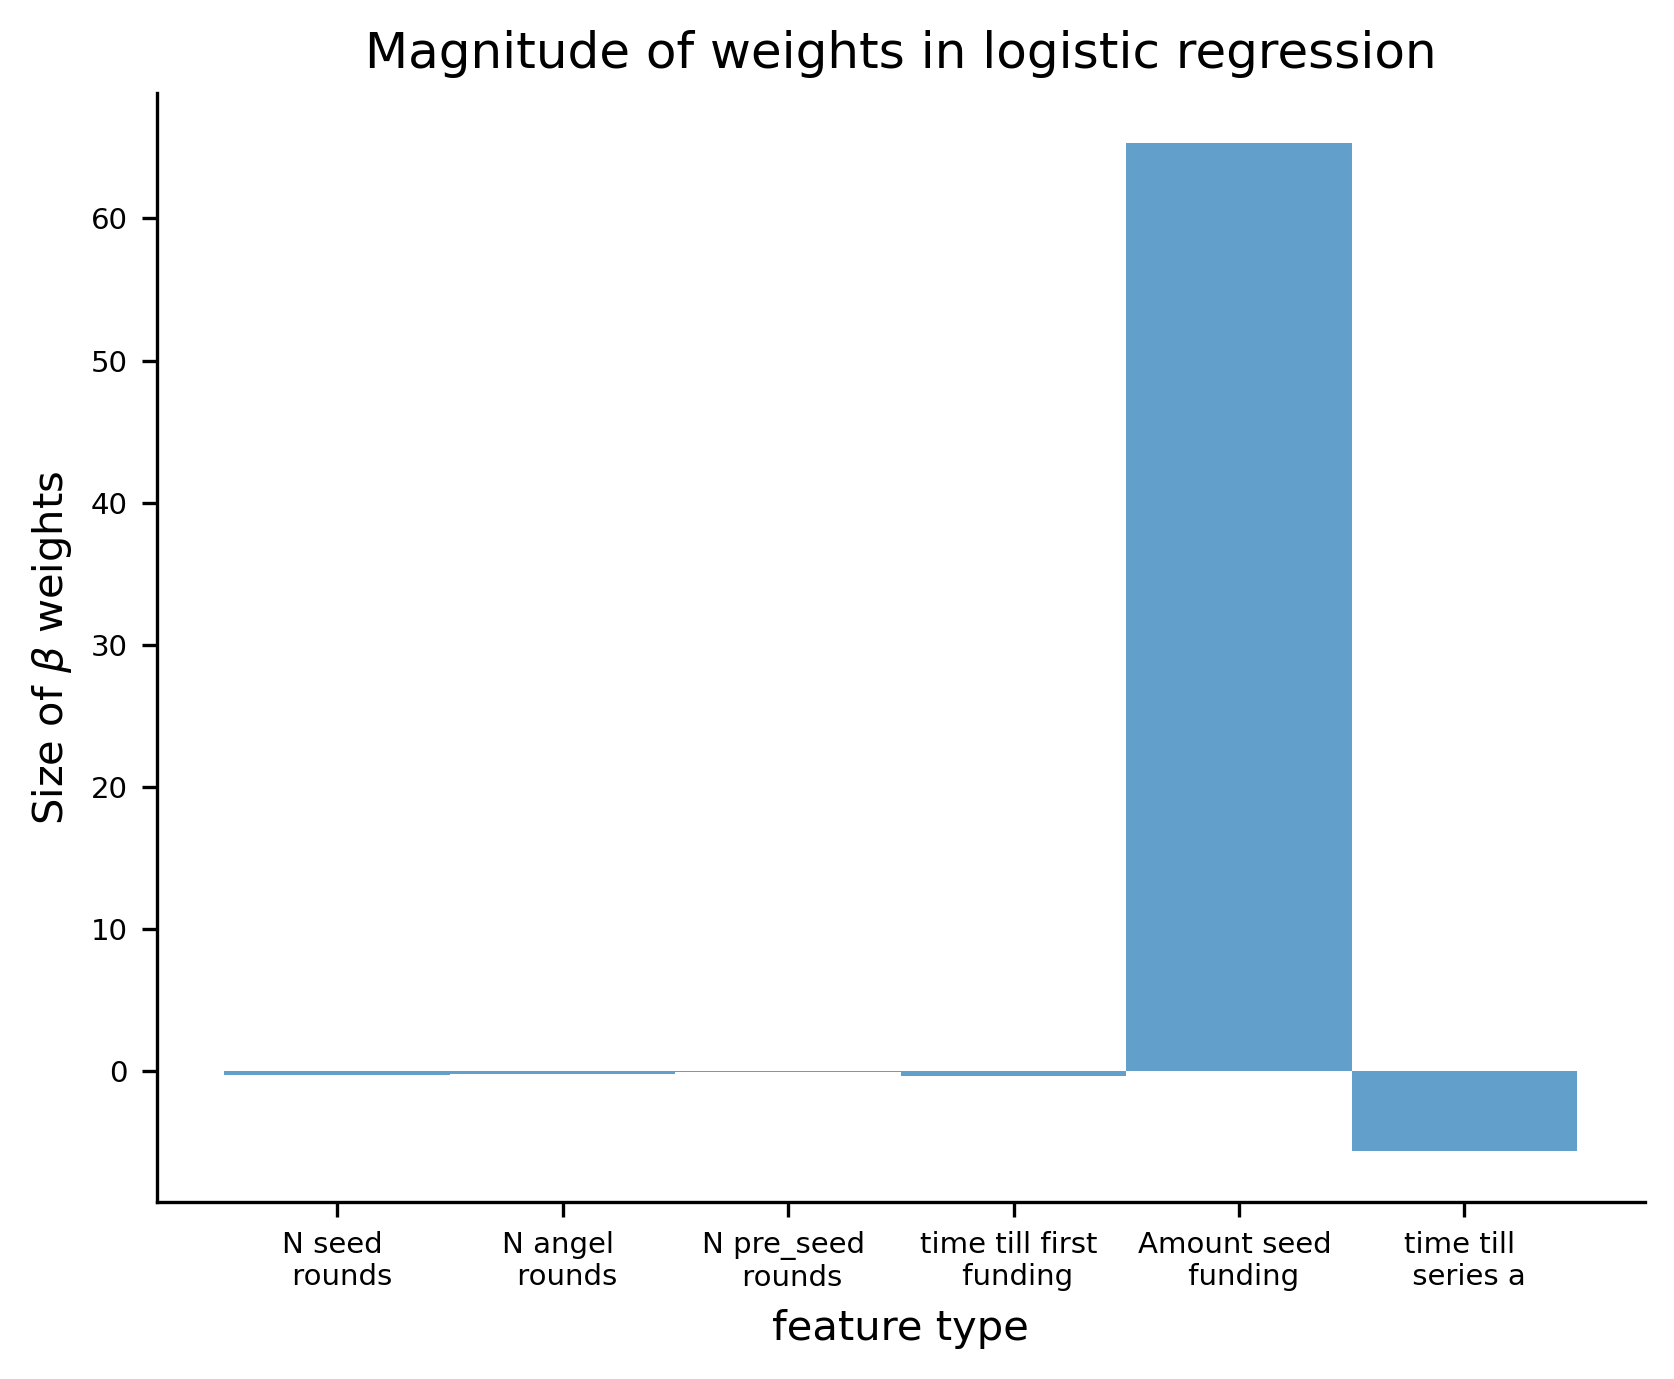

In [182]:
log_reg_model_vanilla.coef_[0]

# lets plot this for successful companies
fig, ax = plt.subplots(dpi=300)
ax.bar(np.arange(1,7), log_reg_model_vanilla.coef_[0], alpha=0.7, width=1.0)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticks(np.arange(1,7))
ax.set_xticklabels(['N seed \n rounds', 
                    'N angel \n rounds',
                    'N pre_seed \n rounds', 
                    'time till first \n funding',
                    'Amount seed \n funding',	
                    'time till \n series a'])
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_xlabel("feature type")
ax.set_ylabel(r'Size of $ \beta $ weights')
ax.set_title('Magnitude of weights in logistic regression')
